## Face image generation using CNN layers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, MaxPooling2D, Reshape, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, Add, Activation, Conv2DTranspose, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16

In [3]:
# Define the new directory path
new_directory = '/content/drive/MyDrive/Colab Notebooks'

# Change the current working directory to the new one
os.chdir(new_directory)

# Verify the change by printing the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/MyDrive/Colab Notebooks


### Defining hyper-parameters

In [4]:
No_images= 5000
img_width, img_height= 64, 64
batch_size = 8
No_epochs= 30

soft_rate= 0.95
learning_rate_gan= 0.0001
learning_rate_dis= 0.0001
decay_steps = 3
decay_rate = 0.65

### Defining a scheduler for Larning rate of models

In [5]:
# Create custom scheduler for learning rate
def lr_scheduler(learning_rate, decay_steps, decay_rate):
    def scheduler(epoch, lr):
        if epoch % decay_steps == 0 and epoch != 0:
            return lr * decay_rate
        else:
            return lr
    return scheduler

# Define the learning rate schedules
gan_lr_schedule = lr_scheduler(learning_rate_gan, decay_steps, decay_rate)
dis_lr_schedule = lr_scheduler(learning_rate_dis, decay_steps, decay_rate)

### Defining directory of data

In [6]:
# Set the directory where the data is stored
data_dir = "Data/Resized Images/"

# Define the labels
images_name= os.listdir(data_dir)[:No_images]

image_path_list= []
for img_name in images_name:
    path = os.path.join(data_dir, img_name)
    image_path_list.append(path)

image_path_list= np.array(image_path_list)

### Inporting images

In [7]:
# Function to load and preprocess images
def load_images(X, img_width, img_height):
    images = []
    for image_path in X:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (img_width, img_height))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # Normalize pixel values
        images.append(image)

    return np.array(images)

# Load and preprocess images
images= load_images(image_path_list, img_width, img_height)

### Showing som sample face images

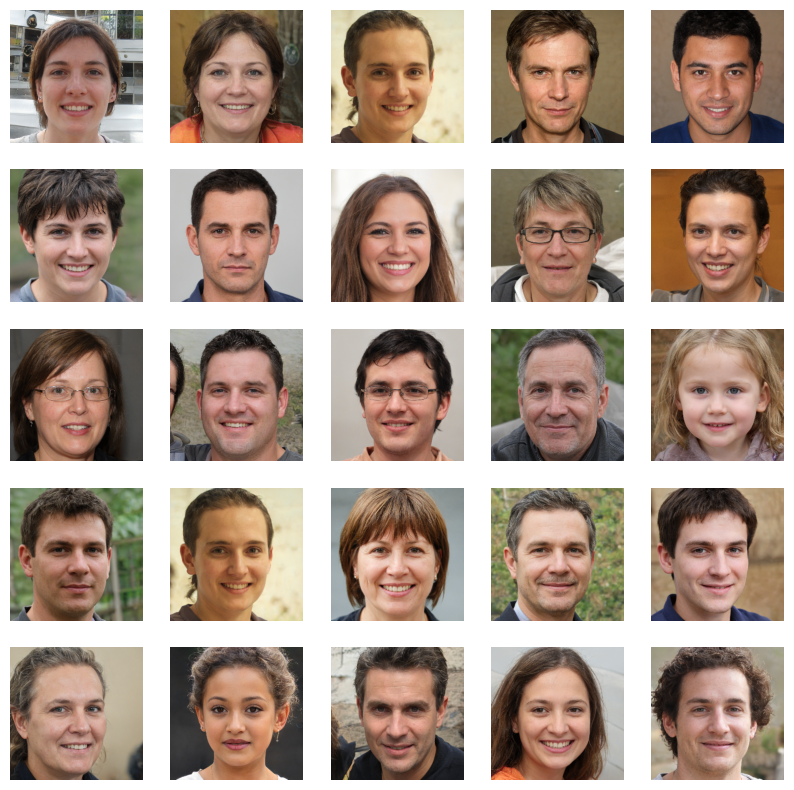

In [ ]:
# Plot the images
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    image = Image.open(np.random.choice(image_path_list))
    plt.imshow(image)
    plt.axis('off')
plt.show()

### Imorting VGG16 as a pre-trained model

In [8]:
# Using base_model for transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False
#base_model.summary()

58889256/58889256 [==============================] - 3s 0us/step


### Setting an augmentation layer

In [9]:
# Defining data augmentation layer
data_augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)])

### Defining the generator model

In [10]:
def make_generator_model(input_shape= (img_width, img_height, 3)):
    inputs = Input(shape= input_shape)
    # Data augmentation layer
    augmen_layer = data_augmentation(inputs)
    x = base_model(augmen_layer)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)  # Adding dropout for regularization
    x = Dense(np.prod(input_shape), activation='sigmoid')(x)
    outputs = Reshape(input_shape)(x)
    return Model(inputs, outputs)

generator= make_generator_model()
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 12288)             158515

### Defining the discriminator model

In [11]:
# Discriminator model
discriminator = Sequential([
    Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(img_width, img_height, 3)),
    LeakyReLU(alpha=0.2),

    Conv2D(128, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Conv2D(256, (4, 4), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Flatten(),

    Dense(50, kernel_regularizer=regularizers.l2(0.002)),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Dense(1, activation='sigmoid')
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         524544    
                                                      

In [12]:
# Compile the discriminator
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate_dis, beta_1=0.5), metrics=['accuracy'])

In [13]:
# Compile the GAN
discriminator.trainable = False

### Defining the GAN model

In [14]:
gan = Sequential([
    Input(shape= (img_width, img_height, 3)),
    generator,
    discriminator])
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 64, 64, 3)         16562112  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 1479917   
                                                                 
Total params: 18042029 (68.82 MB)
Trainable params: 1847424 (7.05 MB)
Non-trainable params: 16194605 (61.78 MB)
_________________________________________________________________


In [15]:
gan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate_gan, beta_1=0.5), metrics=['accuracy'])

### Training two models 

In [16]:
Dis_loss, Gen_loss= [], []
for epoch in range(No_epochs):
    # Update the learning rate for both models
    gan.optimizer.learning_rate = gan_lr_schedule(epoch, gan.optimizer.learning_rate)
    discriminator.optimizer.learning_rate = dis_lr_schedule(epoch, discriminator.optimizer.learning_rate)

    loss_D, loss_G = [], []
    for _ in range(images.shape[0] // batch_size):

        # phase 1 - training the discriminator
        noise = tf.random.normal(shape=[batch_size, img_width, img_height, 3])
        generated_images = generator(noise)

        real_images = images[np.random.randint(0, images.shape[0], batch_size)]

        X_fake_and_real = tf.concat([generated_images, real_images], axis=0)

        y1 = tf.constant([[0.]] * batch_size + [[soft_rate]] * batch_size)

        discriminator_loss= discriminator.train_on_batch(X_fake_and_real, y1)

        # phase 2 - training the generator
        noise = tf.random.normal(shape=[batch_size, img_width, img_height, 3])

        y2 = tf.constant([[1.]] * batch_size) 

        generator_loss= gan.train_on_batch(noise, y2)

        loss_G.append(generator_loss)
        loss_D.append(discriminator_loss)

    Gen_loss.append(np.mean(loss_G))
    Dis_loss.append(np.mean(loss_D))

    print(f'Epoch {epoch + 1}/{No_epochs}, Generator loss: {np.mean(loss_G)}, Discriminator loss: {np.mean(Dis_loss)}')

Epoch 1/30, Generator loss: 1.12922632856369, Discriminator loss: 0.6185387839794159
Epoch 2/30, Generator loss: 3.0666127518892288, Discriminator loss: 0.5692591924190521
Epoch 3/30, Generator loss: 1.0788259541511536, Discriminator loss: 0.5279882715384165
Epoch 4/30, Generator loss: 3.044971757566929, Discriminator loss: 0.4974745343267918
Epoch 5/30, Generator loss: 1.3289319212794304, Discriminator loss: 0.47381727577686317
Epoch 6/30, Generator loss: 1.2538328790545463, Discriminator loss: 0.45486065032482154
Epoch 7/30, Generator loss: 1.8593334195017814, Discriminator loss: 0.4394457055466516
Epoch 8/30, Generator loss: 1.8831569524228573, Discriminator loss: 0.42723068760931493
Epoch 9/30, Generator loss: 1.2119752924084664, Discriminator loss: 0.41715362729231514
Epoch 10/30, Generator loss: 2.128371832883358, Discriminator loss: 0.4088276391434669
Epoch 11/30, Generator loss: 1.203219134914875, Discriminator loss: 0.40173795662034634
Epoch 12/30, Generator loss: 1.3714887984

### Ploting the loss values

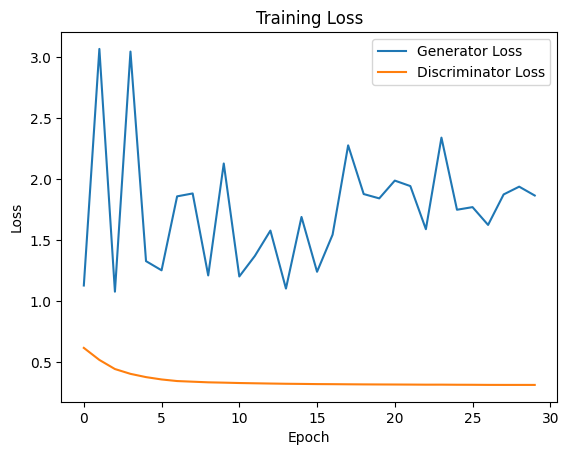

In [17]:
# Plot the loss values
plt.plot(Gen_loss, label='Generator Loss')
plt.plot(Dis_loss, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

### A sample generated model

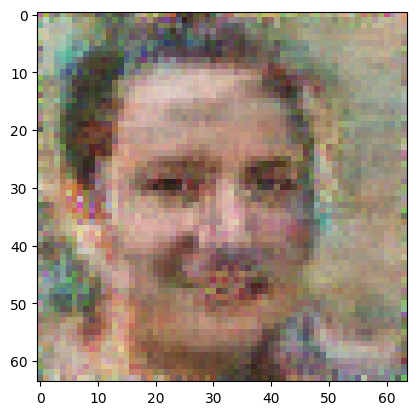

In [18]:
noise = np.random.normal(-1,1,(1, img_width, img_height, 3))
img = generator(noise)
plt.imshow(img[0])
plt.show()